<a href="https://colab.research.google.com/github/zeyysh/Machine-Learning/blob/main/ML_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Zeynab Shiri
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch

In this homework, we will mainly work with transfer learning. In part 1 and part 2, you will use transfer learning to train two models for image segmentation using CNNs and sentiment analyzing using transformers, respectively.

#Part1: Image Segmentation

Image segmentation is dividing a digital image into different subgroups called image segments, simplifying image processing and analysis by reducing its complexity. In this part, your task is to create a model that, by receiving a picture of a pet, determines the pixels belonging to the pet part of the image. 

We use the encoder-decoder framework to do so. The encoder extracts a feature vector from the input image, then the decoder use that features vector to generate a binary mask that determines whether pixels belong to the body of the pet or not.

##Dataset


In this part, you will work with [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), which contains 3680 train and 3669 test samples. Run the following cells below to download the dataset and see an instance of a pet image and its mask.


In [ ]:
trans_to_tensor = transforms.ToTensor()
trans_resize = transforms.Resize((224, 224))
def unify(label):
  label =trans_resize(label)
  label =trans_to_tensor(label)
  label[label<= 0.004] = 1
  label[label >= 0.0117] = 1
  label[label< 1] = 0
  return label

In [ ]:
transform =   transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
dataset_train = torchvision.datasets.OxfordIIITPet(root = 'dataset/train', split='trainval', transform=transform,target_transform= unify,target_types='segmentation',  download=True)
dataset_test = torchvision.datasets.OxfordIIITPet(root = 'dataset/test', split='test', transform=transform,target_transform= unify,target_types='segmentation',  download=True)

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting dataset/train/oxford-iiit-pet/images.tar.gz to dataset/train/oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

In [ ]:
dataset_train

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
Target transform: <function unify at 0x7fd03929c430>

In [ ]:
dataset_test

Dataset OxfordIIITPet
    Number of datapoints: 3669
    Root location: dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
Target transform: <function unify at 0x7fd03929c430>

In [ ]:
img, label = dataset_train[59]

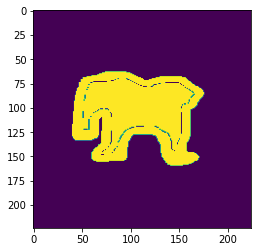

In [ ]:
#illustration the mask
plt.figure()
plt.imshow(label[0,:,:])

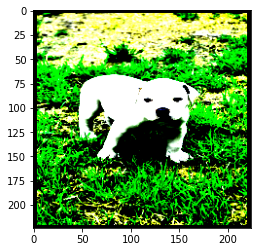

In [ ]:
#illustration the iamge
plt.figure()
plt.imshow(img.permute(1, 2, 0))

##Model

Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task. There are bunches of CNN models that are trained on a huge dataset for classification tasks, e.g., ResNet, [VGG19](https://arxiv.org/pdf/1409.1556.pdf), and so on. So, instead of training the model from scratch (starting from randomly initialized weights), we use VGG19 as the encoder part. This way, our model would converge faster, and a lot of computation and time would be saved. For the sake of time and size of the dataset, we use VGG16 as it is and do not train it, i.e., we freeze the encoder parameter during training. 

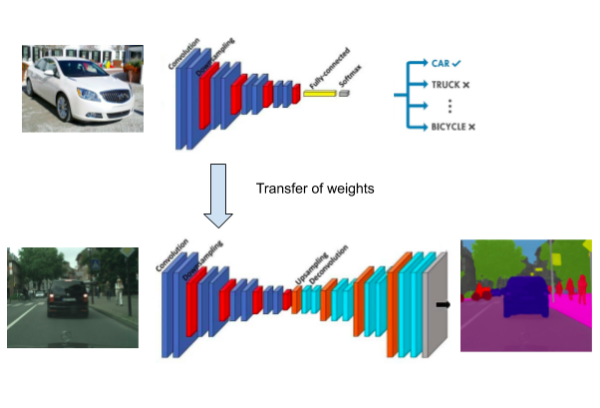

###Encoder

The architecture of VGG19 is shown in the image below. It contains a series of convolution layers with different sizes followed by two dense layers. 

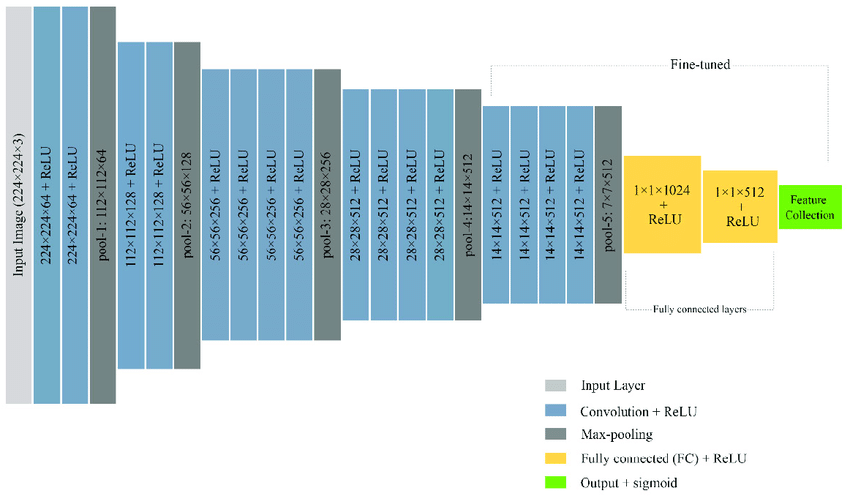

Using the cell below, load the VGG19 model.

In [ ]:
vgg19 = torchvision.models.vgg19(weights= 'DEFAULT')
vgg19


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

We only need the CNN part of the model. Complete the cell below to extract `vgg19` until the last max pool layer (without the max pool itself) and save it as your encoder.

In [ ]:

encoder =  #ToDo

###Decoder

As you can see encoder gets a $244\times244$ image and downsamples it to a $14\times14$ feature map through the multiple layers. We want our decoder to follow the pattern of the encoder but obviously in the reverse direction; namely, instead of the convolution layer (`Conv2d`) and max-pooling (`MaxPool2d`), we will use transposed convolution layer (`ConvTranspose2d`) and upsampling (`UpsamplingNearest2d`). You can see the desired architecture of the decoder in the image below. 

(Use  ReLU as the activation function for `ConvTranspose2d` layers )

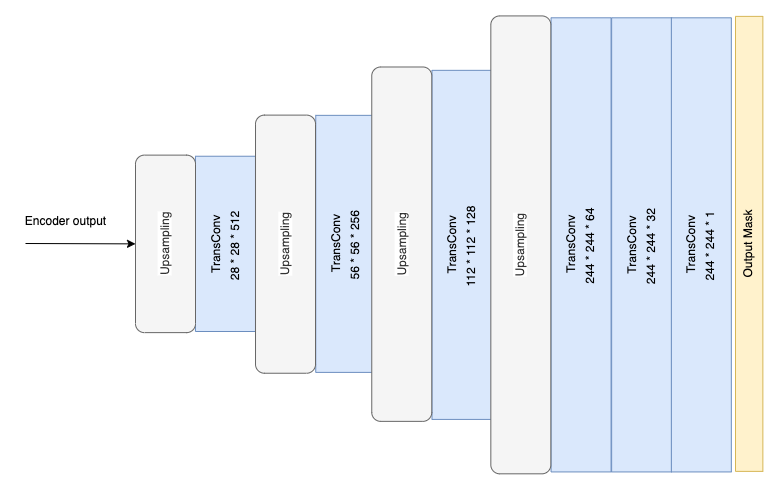

you can set:



*   `kernel_size` = 3
*   `stride` = 1
*   `padding` = 1
*   `output_padding` = 0

for  `ConvTranspose2d` layers.


Explain each of these items and how they affect the output.

<font color='red'>Answer Here</font>


---



Each pixel of the output mask should show the probability that the corresponding pixel in the image belongs to the pet body (so, do not forget about sigmoid!).

In [ ]:
class Decoder(nn.Module):




  def __init__(self):
        super().__init__()
  
        #ToDo




  def forward(self, x):

      #ToDo





decoder = Decoder()

In [ ]:
class Segmentation(nn.Module):

  def __init__(self, enc, dec):
        super().__init__()
        #ToDo


  def forward(self, image):
        #ToDo



In [ ]:
model = #instantiate it from the Segmentation model

##Training

Since we want the encoder to be frozen during training, wirte a code to freeze the model encoder.

In [ ]:
#freeze the encoder of your model
#ToDO

Since it is a relatively computation-intensive task, please use GPU.

In [ ]:
#ToDo

You can use these values for hyperparameters but feel free to change them.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64
learning_rate = 5e-4
weight_decay=1e-05
epochs = 10


train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

use binary cross entropy for the loss and adam for the optimizer (you are always allowed to use the other correct options).

In [ ]:
optim = #ToDo
loss =  #ToDo


Complete the cell below to train your model. Train it for more than 10 epochs and at the end of each epoch report the loss value.

In [ ]:
from tqdm.notebook import tqdm  #you can use this to monitor training process


def train(model, loss_function, optimizer, train_loader, epochs):

    train_losses = []

    for i in range(epochs):
      
        
        #ToDo


    return train_losses

In [ ]:
train_losses = train(model, loss, optim, train_loader, epochs)

##Test

Now enjoy the result of your hard work!

In [ ]:
!def thresholding_mask(mask, thr = 0.5):
    mask[mask < thr] = 0
    mask[mask >= thr] = 1
    return mask


In [ ]:
model.cpu()
mask = model(dataset_test[75][0].view(1,3, 224, 224))

In [ ]:
mask = thresholding_mask(mask)

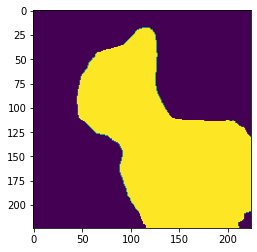

In [ ]:
plt.imshow(mask.detach()[0,0,:,:])

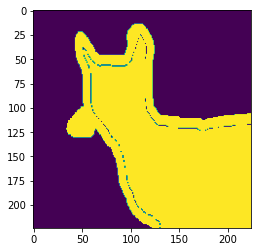

In [ ]:
plt.imshow(dataset_test[75][1][0,:,:])

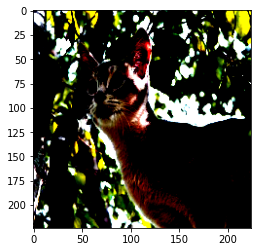

In [ ]:
plt.imshow(dataset_test[75][0].permute(1, 2, 0))

##Optional

Find a proper metric for the segmentation task and explain it. Use your metric to measure how well your model works on the test dataset.

#Part2: Sentiment Analyzing

Sentiment analysis is the task of classifying the polarity of a given text. For instance, a text-based tweet can be categorized into either "positive" or "negative". Given the text and accompanying labels, a model can be trained to predict the correct sentiment.

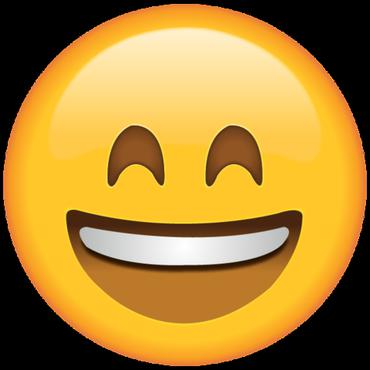

In this part, you will use a pre-trained model from the [huggingface](huggingface.co) and fine-tune it for the sentiment analyzing task using the provided dataset. Fine-tuning a pre-trained model is a common practice to build a model for downstream tasks in the NLP world!

All you need to know for this part is in this [link](https://huggingface.co/docs/transformers/training)!

## .

In [ ]:
from google.colab import output

In [ ]:
!pip install datasets
!pip install transformers
output.clear()

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import numpy as np
from datasets import load_metric
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
 

##Dataset

The dataset for this part is [IMDB dataset](https://huggingface.co/datasets/imdb), a large movie review Dataset. It is a dataset for binary sentiment classification containing 25,000 highly polar movie reviews for training and 25,000 for testing.



Use the cell below to load the dataset from huggingface.

In [ ]:
imdb = load_dataset("imdb")

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train_dataset = imdb["train"].shuffle(seed=42)
test_dataset = imdb["test"].shuffle(seed=42)

In [ ]:
print(train_dataset['text'][50])
print(train_dataset['label'][50])

When I was a kid, I totally loved both Bill & Ted Movies. The other night, Bogus Journey was on and since it was at least 5 years since I last saw it, I decided to tune in. AND I LOVED IT ALL OVER AGAIN! This film is still funny after all those years. 'Excellent Adventure' is better, but this one rocks just the same. Sure, some of the perfomances are a bit cheesy, but hey, this entire film is cheesy in a cool way. Plus it features the coolest personation of Death ever in a movie! Concluding: Totally like non bogus movie dude! Way Excellent! STATION!!!
1


In [ ]:
print(train_dataset['text'][100])
print(train_dataset['label'][100])

There is no artistic value in this movie to deserve any award. Well, it does not deserve an audience as well. Ironically, one of the awards is for cinematography but frankly, the camera movements are disconcerting to say the least. Every frame, you feel you are getting the "full picture", its like someone is "cropping your view" from the edges. The story is pathetic. Well, I will be honest, I could not bear to watch the entire movie. The part that sucked the most was when I saw the soldiers partying in their barracks and one of the soldiers coaxed to drink liquor. These and many other similar scenes reminded me so much of Steven Seagal.<br /><br />Take my advice, stay away from this piece of crap.
0


##Loading and Tokenizing

As the pre-trained model, we will use BERT (Bidirectional Encoder Representations from Transformers), one of the very first pre-trained models.

Load the tokenizer and model as described in the tutorial.

In [ ]:
check_point = "bert-base-uncased"
tokenizer = 
sentiment_model = 

There is also another checkpoint called "bert-base-cased", study how these two checkpoints are different.

<font color='red'>Answer Here</font>


---



Define the `pre-process` function and apply it to the train and test dataset to tokenize the samples.

In [ ]:

#ToDo




Explain the `padding` and `truncation` inputs of the tokenizer. 

<font color='red'>Answer Here</font>


---



See a sample of tokenized train dataset and answer these questions:



*   What is input-ids?
*   What is attention_mask?

please do not just copy or translate the huggingface sentences!



<font color='red'>Answer Here</font>


---



##Training

Complete the function below to calculate the accuracy of your predictions. You will use this function to evalute the model on the test dataset during training.

In [ ]:
 def compute_metrics(eval_pred):
   
    #ToDo

In [ ]:

data_collator = #ToDo

For training, use huggingface `Trainer` API. 
Apply the list below in the training process:


*   Train your model for 1000 steps
*   Evaluate your model for each 250 steps
*   At the end, load the checkpoint of the best model
*   Choose a proper batch size and learning rate



In [ ]:


training_args = #ToDo
 
trainer = #ToDo


What does "step" indicate in the training process?

<font color='red'>Answer Here</font>


---



Now train your model.

In [ ]:
trainer.train()

##Testing

Test your model on the sentence below.

In [ ]:
import torch
input = tokenizer('This movie disappointed me.')
sentiment_model.cpu()
sentiment_model(torch.tensor(input['input_ids']).view(1,-1))

Good Luck.